In [49]:
import numpy as np
from pathlib import Path
from collections import defaultdict as ddict
from collections import OrderedDict as odict
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

### 1. transform dk data with new labels

In [3]:
def labNew2Old(string):
    prefix = "ctx-"
    itm1, itm2 = string.split(".")
    return prefix + itm1 + "-" + itm2

In [6]:
filDir = Path("../data/brain_plot_meg/")

fcROld = pd.read_csv(filDir/'DK_dictionary_normalized.csv').set_index('Unnamed: 0')
dkLabs = pd.read_excel(filDir/'DK_labs_list.xlsx')
fcRarr = np.array(fcROld)

oldLabs = list(fcROld.columns)
dkLabs = list(np.array(dkLabs).reshape(-1))

In [25]:
fcRNewDic = odict()

for lab in dkLabs:
    oldlab = labNew2Old(lab)
    fcRNewDic[oldlab] = list(fcROld[oldlab])
    
fcRNew = pd.DataFrame(fcRNewDic)
fcRNew.index = fcROld.index
fcRNew.to_csv(filDir/"DK_dic68.csv")

### 2. Obtain the U, weighted U and corresponding correlation for fMRI data

In [50]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")
from pyTVDN.tmpUtils import *
import pickle
import scipy.stats as ss

#### Get the fcR

In [51]:
fcRDF = pd.read_csv("../necessary files/AALICA.csv")
fcR = np.array(fcRDF)[:90, :]
names = list(fcRDF.columns)
names = [name.strip() for name in names]

fcR = np.array([minmax(fcR[:, i]) for i in range(7)])
fcR = fcR.T

#### U 

In [138]:
datDir = Path("../results/fMRIHPFs_sep")
fil = list(datDir.glob("*diseased.pkl"))[0]
print(fil)

with open(fil, "rb") as f:
    TVDNres = pickle.load(f)
    
Us = []
for DetObj in TVDNres.DetObjs:
    r = DetObj.paras.r
    rUs = DetObj.midRes.eigVecs[:, :r]
    kpidxs = np.where(np.diff(np.concatenate([[np.Inf], np.abs(rUs[0, :])])) != 0)[0]
    for ix in kpidxs:
        Us.append(rUs[:, ix])
        
absUs = np.array(np.abs(Us))
absUsList =[minmax(absUs[i, :]) for i in range(absUs.shape[0])]
absUs = np.array(absUsList)

../results/fMRIHPFs_sep/fMRIResultAdap_diseased.pkl


#### Clustering 

In [81]:
from sklearn.cluster import KMeans

In [122]:
for nCluster in [3, 4, 5, 6, 7]:
    kmeans = KMeans(n_clusters=nCluster, random_state=0).fit(absUs)
    cCorrs = ddict(list)
    for i in range(nCluster):
        kpIdxs = kmeans.labels_ == i
        cUs = absUs[kpIdxs, :]
        cMean = cUs.mean(axis=0)
        for j, name in enumerate(names):
            cCorrs[name].append(ss.pearsonr(fcR[:, j], cMean)[0])
    cCorDF = pd.DataFrame(cCorrs)
    cCorArr = np.array(cCorDF)
    np.savetxt(datDir/f"cluster{nCluster}_corr.txt", cCorArr)
    print(f"The number of clusters is {nCluster}.")
    display(cCorDF)

The number of clusters is 3.


,Visual,Somatomotor,Dorsal_Attention,Ventral_Attention,Limbic,Frontoparietal,Default
0,0.301254,-0.259081,-0.029738,-0.230730,0.125186,0.006549,-0.163898
1,-0.096816,-0.254794,0.048327,-0.198525,0.312243,0.293098,-0.012098
2,-0.007244,-0.246828,0.064087,-0.179185,0.237546,0.201875,-0.031302


The number of clusters is 4.


,Visual,Somatomotor,Dorsal_Attention,Ventral_Attention,Limbic,Frontoparietal,Default
0,0.304547,-0.250770,-0.037467,-0.227719,0.128268,0.011242,-0.176546
1,-0.082388,-0.231394,0.212263,-0.109648,0.292866,0.223797,-0.001179
2,0.062826,-0.260457,-0.024913,-0.234304,0.194888,0.154484,-0.038319
3,-0.081943,-0.242214,-0.014023,-0.202892,0.284704,0.296483,-0.034422


The number of clusters is 5.


,Visual,Somatomotor,Dorsal_Attention,Ventral_Attention,Limbic,Frontoparietal,Default
0,0.288776,-0.251956,-0.030705,-0.238263,0.136871,0.007992,-0.174477
1,-0.083118,-0.224559,0.229354,-0.094533,0.279143,0.214092,-0.000219
2,-0.085928,-0.226875,-0.004707,-0.191977,0.340608,0.308058,-0.067049
3,-0.031199,-0.255616,-0.054583,-0.217899,0.160720,0.196382,0.049735
4,0.125405,-0.251920,0.002591,-0.216896,0.197866,0.143566,-0.095861


The number of clusters is 6.


,Visual,Somatomotor,Dorsal_Attention,Ventral_Attention,Limbic,Frontoparietal,Default
0,-0.046156,-0.262895,-0.101361,-0.221475,0.200055,0.221850,0.061881
1,-0.103505,-0.234850,-0.038975,-0.186569,0.373212,0.306392,-0.062784
2,0.300835,-0.251626,-0.040510,-0.228400,0.139351,-0.005637,-0.183766
3,0.106765,-0.240434,0.014686,-0.199527,0.182805,0.145311,-0.095344
4,-0.078000,-0.238564,0.199512,-0.102766,0.333720,0.199459,-0.003541
5,0.047439,-0.193437,0.123107,-0.201809,0.051700,0.177335,-0.022157


The number of clusters is 7.


,Visual,Somatomotor,Dorsal_Attention,Ventral_Attention,Limbic,Frontoparietal,Default
0,0.360678,-0.244310,0.004242,-0.191215,0.135261,0.156452,-0.149400
1,-0.088300,-0.242286,0.238407,-0.113685,0.307305,0.217202,-0.002165
2,-0.080928,-0.197644,-0.030675,-0.112711,-0.012013,0.140530,0.117049
3,0.245300,-0.227310,-0.023751,-0.224358,0.098975,-0.032557,-0.158381
4,-0.098762,-0.251712,-0.091382,-0.212760,0.441223,0.289085,-0.037200
5,-0.043949,-0.213764,0.021362,-0.194740,0.278759,0.295430,-0.083485
6,0.013456,-0.255456,0.025478,-0.246440,0.237804,0.100826,-0.069377


#### correlation

In [117]:
corrs = ddict(list)
for absU in absUs:
    for j, name in enumerate(names):
        corrs[name].append(ss.pearsonr(fcR[:, j], absU)[0])
        
corDF = pd.DataFrame(corrs)
corArr = np.array(corDF)

np.savetxt(datDir/"allCorr_diseased.txt", corArr)

### Num of change points comparison

In [6]:
numCpts = []
for DetObj in TVDNres.DetObjs:
    numCpts.append(len(DetObj.ecpts))
    
numCptsH = numCpts[:103]
numCptsD = numCpts[103:]

In [26]:
bins = np.arange(0.5, 13, 1)
nums = np.arange(1, 13, 1)
countsH, _ = np.histogram(numCptsH, bins=bins)
countsD, _ = np.histogram(numCptsD, bins=bins)
ratesH = countsH/np.sum(countsH)
ratesD = countsD/np.sum(countsD)

<BarContainer object of 12 artists>

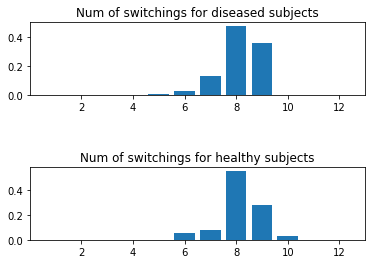

In [27]:
plt.subplots_adjust(wspace =0, hspace=1)
plt.subplot(211)
plt.title("Num of switchings for diseased subjects")
plt.bar(nums, ratesD)
plt.subplot(212)
plt.title("Num of switchings for healthy subjects")
plt.bar(nums, ratesH)

### Correlation  of demo 

In [148]:
idx = 83 # 91 
DetObj = TVDNres.DetObjs[idx]
r = DetObj.paras.r
rUs = DetObj.midRes.eigVecs[:, :r]
kpidxs = np.where(np.diff(np.concatenate([[np.Inf], np.abs(rUs[0, :])])) != 0)[0]
Us = rUs[:, kpidxs]

absUs = np.array(np.abs(Us)).T
absUsList =[minmax(absUs[i, :]) for i in range(absUs.shape[0])]
absUs = np.array(absUsList)


abswUs = obtainAbswU(DetObj)
abswUsList = [minmax(abswUs[:, i]) for i in range(abswUs.shape[1])]
abswUs = np.array(abswUsList)

abswUs2 = obtainAbswU2(DetObj)
abswUsList2 = [minmax(abswUs2[:, i]) for i in range(abswUs2.shape[1])]
abswUs2 = np.array(abswUsList2)

#### Corr of U

In [149]:
#corrs = ddict(list)
#for absU in absUs:
#    for j, name in enumerate(names):
#        corrs[name].append(ss.pearsonr(fcR[:, j], absU)[0])
#        
#corDF = pd.DataFrame(corrs)
#corDF

#### Corr of wU

only need this way

In [150]:
wUcorrs = ddict(list)
for abswU in abswUs:
    for j, name in enumerate(names):
        wUcorrs[name].append(ss.pearsonr(fcR[:, j], abswU)[0])
        
wUcorDF = pd.DataFrame(wUcorrs)
wUcorDF.to_csv(datDir/f"fMRI_diseased_demo_{idx}_corr1.csv")
wUcorDF

,Visual,Somatomotor,Dorsal_Attention,Ventral_Attention,Limbic,Frontoparietal,Default
0,-0.237328,-0.035299,0.151418,0.195938,0.012915,-0.049335,-0.015213
1,-0.043710,-0.177802,0.191718,-0.121527,0.071751,0.006832,-0.039071
2,0.177300,-0.076371,0.237976,-0.125766,-0.090191,-0.205484,-0.162688
3,0.056058,-0.178190,0.116365,-0.053986,0.112265,-0.137037,-0.161805
4,-0.149230,0.001030,0.168267,0.005225,0.100967,-0.027634,-0.117793
5,0.247442,-0.163430,-0.089287,-0.166231,0.244220,-0.139172,0.021413
6,0.147113,0.000467,0.097390,0.023793,-0.023310,0.179100,-0.167980
7,0.241696,-0.114554,-0.083194,-0.116652,0.068475,-0.324563,-0.040386
8,-0.204911,0.028072,0.112219,0.129784,-0.153176,-0.026498,0.298860


#### Corr of wU via second way

In [93]:
wUcorrs2 = ddict(list)
for abswU in abswUs2:
    for j, name in enumerate(names):
        wUcorrs2[name].append(ss.pearsonr(fcR[:, j], abswU)[0])
        
wUcorDF2 = pd.DataFrame(wUcorrs2)
wUcorDF2
#wUcorDF2.to_csv(datDir/f"fMRI_healthy_demo_{idx}_corr2.csv")

,Visual,Somatomotor,Dorsal_Attention,Ventral_Attention,Limbic,Frontoparietal,Default
0,0.020633,-0.079228,0.257431,-0.061685,0.052457,0.302326,-0.116918
1,0.007661,-0.085290,0.202831,-0.047691,0.038531,0.278473,-0.103414
2,0.035994,-0.104172,0.220435,-0.051895,0.046526,0.217209,-0.111476
3,0.005403,-0.093509,0.141195,-0.055939,0.029360,0.270389,-0.084756
4,-0.002727,-0.044580,0.299714,-0.017482,0.048518,0.278419,-0.125118
5,-0.003812,-0.046566,0.304097,-0.004169,0.046544,0.253256,-0.128532
6,0.004522,-0.063424,0.280571,-0.016351,0.045754,0.250020,-0.124669
7,0.002627,-0.088111,0.156095,-0.065642,0.033206,0.310300,-0.087829


### Save the weights and U  for each subject

fMRI datasets are divided into two groups healthy and diseased group

In [166]:
resDir = Path("../results")

saveDir = resDir/"fMRIHPFs_sep"
with open(saveDir/"fMRIResultAdap_healthy.pkl", "rb") as f:
    resultsH = pickle.load(f)
    
saveDir = resDir/"fMRIHPFs_sep"
with open(saveDir/"fMRIResultAdap_diseased.pkl", "rb") as f:
    resultsD = pickle.load(f)

In [167]:
Ddics = []
for DetObj in resultsD.DetObjs:
    cDic = {}
    r = DetObj.paras.r
    rUs = DetObj.midRes.eigVecs[:, :r]
    cDic["eigVals"] = DetObj.RecResCur.LamMs
    cDic["Us"] = rUs
    Ddics.append(cDic) 
with open(saveDir/"diseased_eigvals_vecs.pkl", "wb") as f:
    pickle.dump(Ddics, f)

In [168]:
Hdics = []
for DetObj in resultsH.DetObjs:
    cDic = {}
    r = DetObj.paras.r
    rUs = DetObj.midRes.eigVecs[:, :r]
    cDic["eigVals"] = DetObj.RecResCur.LamMs
    cDic["Us"] = rUs
    Hdics.append(cDic) 
with open(saveDir/"healthy_eigvals_vecs.pkl", "wb") as f:
    pickle.dump(Hdics, f)

### Save the results for all data

In [169]:
resDir = Path("../results")

saveDir = resDir/"fMRIHPFs_rankAdap"
with open(saveDir/"fMRIResultAdapM8.pkl", "rb") as f:
    results = pickle.load(f)

In [170]:
Adics = []
for DetObj in results.DetObjs:
    cDic = {}
    r = DetObj.paras.r
    rUs = DetObj.midRes.eigVecs[:, :r]
    cDic["eigVals"] = DetObj.RecResCur.LamMs
    cDic["Us"] = rUs
    Adics.append(cDic) 
with open(saveDir/"all_eigvals_vecs.pkl", "wb") as f:
    pickle.dump(Adics, f)

### compare the results when seperation or not

In [172]:
ranksAllD = []
ranksAllH = []
ranksSepD = []
ranksSepH = []

for i in range(103):
    ranksSepH.append(resultsH.DetObjs[i].paras.r)
    ranksAllH.append(results.DetObjs[i].paras.r)
    
for i in range(140):
    ranksSepD.append(resultsD.DetObjs[i].paras.r)
    ranksAllD.append(results.DetObjs[i+103].paras.r)

In [173]:
np.array(ranksAllH) - np.array(ranksSepH)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [174]:
np.array(ranksAllD) - np.array(ranksSepD)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [182]:
ranksAllD2 = []
ranksAllH2 = []
ranksSepD2 = []
ranksSepH2 = []
for i in range(103):
    ranksSepH2.append(Hdics[i]["Us"].shape[1])
    ranksAllH2.append(Adics[i]["Us"].shape[1])
    
for i in range(140):
    ranksSepD2.append(Ddics[i]["Us"].shape[1])
    ranksAllD2.append(Adics[i+103]["Us"].shape[1])

In [183]:
np.array(ranksAllH2) - np.array(ranksSepH2)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [184]:
np.array(ranksAllD2) - np.array(ranksSepD2)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])